Things to try...

- Use word_detail info somehow to help guide to model towards better phoneme prediction
- Use BatchNorm or other techniques to get over the plateaus in the training process
- XXXX

# Preprocess TIMIT dataset

## Download dataset to machine

In [321]:
%load_ext autoreload
%autoreload 2

import os

DATA_DIR = 'data/timit-dataset-kaggle'
DATASET_ZIP = f'{DATA_DIR}/darpa-timit-acousticphonetic-continuous-speech.zip'

# If statements save time on rerunning this cell
if not os.path.exists(DATA_DIR):
  !mkdir -p {DATA_DIR}
  !kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech -p {DATA_DIR}

import zipfile
if os.path.exists(DATASET_ZIP):
  with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
      zip_ref.extractall(DATA_DIR)
  !rm -f {DATASET_ZIP}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load dataset in HF Dataset format

In [322]:
import os
import evaluate
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

os.environ["WANDB_DISABLED"] = "true"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

raw_datasets = load_dataset("timit_asr", data_dir='data/timit-dataset-kaggle', trust_remote_code=True)

In [323]:
raw_datasets['train'].features

{'file': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'text': Value(dtype='string', id=None),
 'phonetic_detail': Sequence(feature={'start': Value(dtype='int64', id=None), 'stop': Value(dtype='int64', id=None), 'utterance': Value(dtype='string', id=None)}, length=-1, id=None),
 'word_detail': Sequence(feature={'start': Value(dtype='int64', id=None), 'stop': Value(dtype='int64', id=None), 'utterance': Value(dtype='string', id=None)}, length=-1, id=None),
 'dialect_region': Value(dtype='string', id=None),
 'sentence_type': Value(dtype='string', id=None),
 'speaker_id': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None)}

In [324]:
# Add utterance and phoneme_start_idx features to both train and test datasets
def add_features(sample):
    sample['utterance'] = sample['phonetic_detail']['utterance']
    sample['phoneme_start_idx'] = sample['phonetic_detail']['start']
    sample['labels'] = { 
      'phoneme_start_idx': sample['phonetic_detail']['start'],
      'utterance': sample['phonetic_detail']['utterance']
    }
    return sample

raw_datasets['train'] = raw_datasets['train'].map(add_features)
raw_datasets['test'] = raw_datasets['test'].map(add_features)

## Basic data analysis

#### Phoneme Normalization
TODO: Is this actually throwing away using information? We may really care about this phonemes that we're normalizing away.

In [325]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
"""
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(phoneme):
    return phon61_map39[phoneme]

def normalize_phones(sample):
    sample['labels']['utterance'] = [convert_phon61_to_phon39(utterance) for utterance in sample['labels']['utterance']]
    return sample

train_dataset_normalized = raw_datasets['train'].map(normalize_phones)
test_dataset_normalized = raw_datasets['test'].map(normalize_phones)
""";

#### Count & chart phoneme distribution

In [326]:
def get_phoneme_list_from_dataset(dataset):
    return [
        phoneme
        for x in dataset['labels']
        for index, phoneme in zip(
            x['phoneme_start_idx'],
            x['utterance'])
    ]

In [327]:
train_all_phonemes = get_phoneme_list_from_dataset(raw_datasets['train'])
test_all_phonemes = get_phoneme_list_from_dataset(raw_datasets['test'])

phone_vocabs = set(train_all_phonemes)
# eliminate h# for visualization purposes
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    return [phone_counts[phone] for phone in phone_vocabs] 

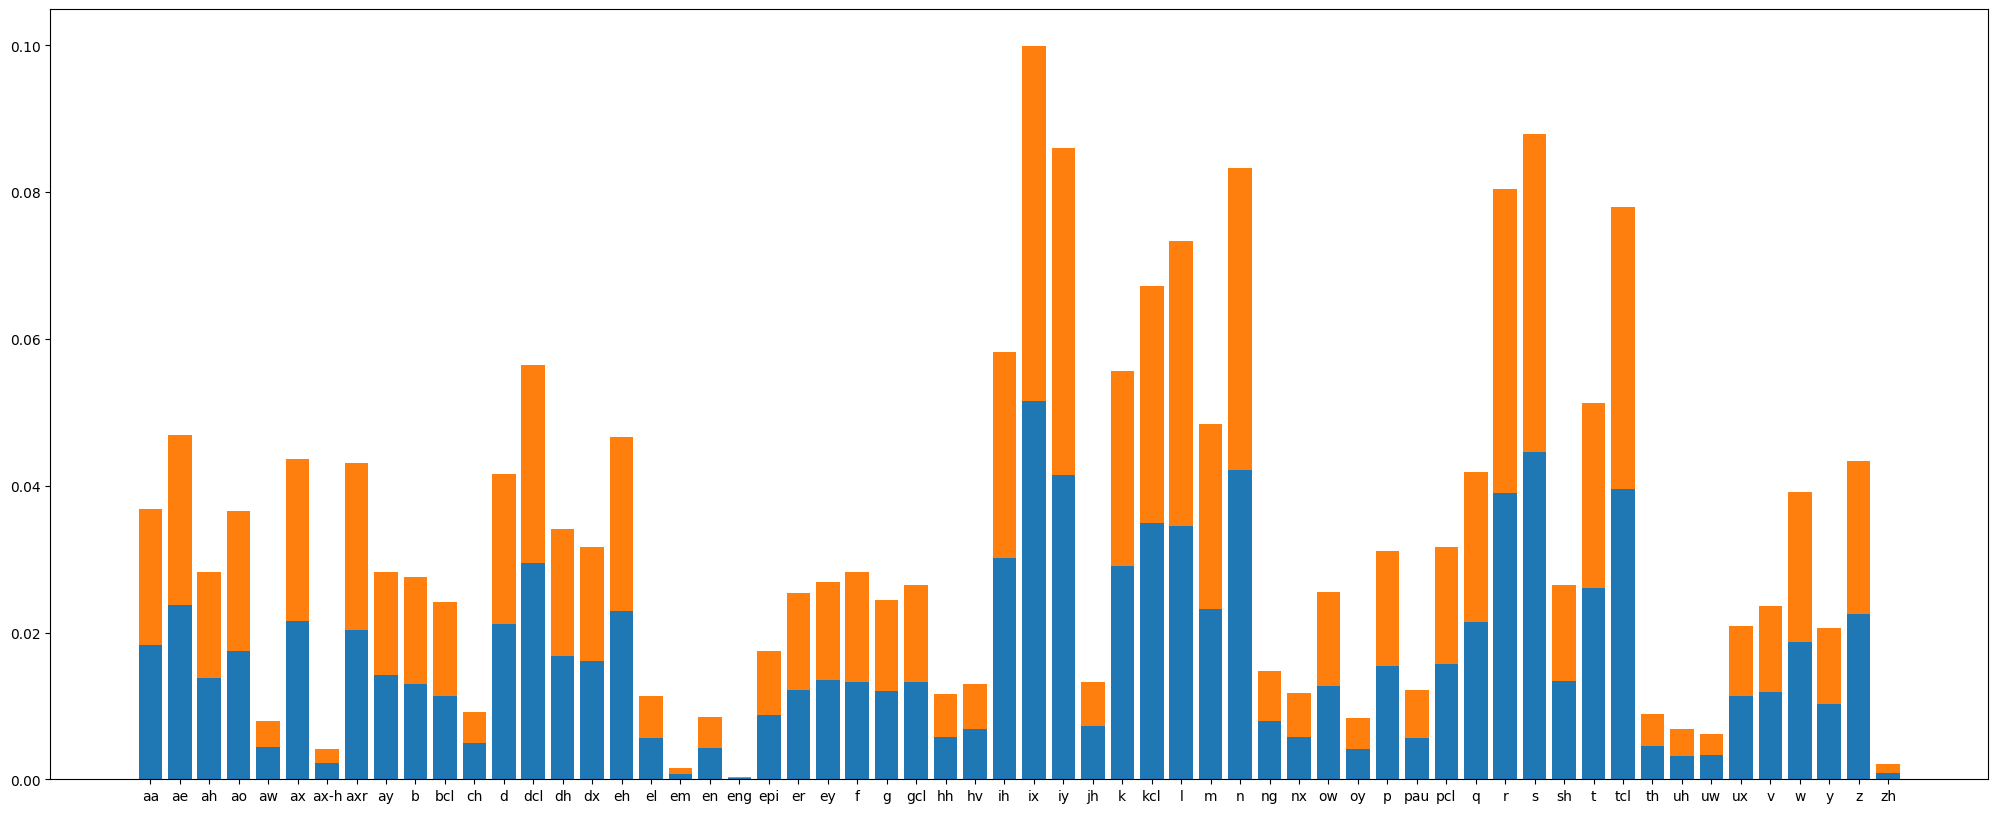

In [328]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

# Plot train_phoneme counts
train_phoneme_counts = count_frequency(train_all_phonemes)
train_phoneme_ratio = [count / sum(train_phoneme_counts) for count in train_phoneme_counts]
plt.bar(phone_vocabs, train_phoneme_ratio)

# Plot test_phoneme counts
test_phoneme_counts  = count_frequency(test_all_phonemes)
test_phoneme_ratio  = [count / sum(test_phoneme_counts) for count in test_phoneme_counts]
plt.bar(phone_vocabs, test_phoneme_ratio, bottom=train_phoneme_ratio)

plt.show()

#### Show sample

In [329]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(raw_datasets['train'])-1)

print("Text:", raw_datasets['train'][rand_int]["text"])
print("Utterances:", raw_datasets['train'][rand_int]["utterance"])
print("Phoneme Start Indices:", raw_datasets['train'][rand_int]["phoneme_start_idx"])
print("Input array shape:", raw_datasets['train'][rand_int]["audio"]["array"].shape)
print("Sampling rate:", raw_datasets['train'][rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=raw_datasets['train'][rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: She had your dark suit in greasy wash water all year.
Utterances: ['h#', 'sh', 'iy', 'hv', 'eh', 'dcl', 'y', 'er', 'dcl', 'd', 'aa', 'r', 'kcl', 'k', 's', 'ux', 'dx', 'ix', 'n', 'gcl', 'g', 'r', 'iy', 's', 'iy', 'w', 'aa', 'sh', 'epi', 'w', 'ao', 'dx', 'axr', 'ao', 'l', 'y', 'ih', 'er', 'h#']
Phoneme Start Indices: [0, 2220, 3760, 4929, 5848, 6936, 7808, 8400, 9450, 10290, 10420, 12193, 13080, 14245, 14880, 16219, 18214, 18600, 19880, 21040, 21843, 22317, 23080, 24210, 25930, 27154, 28449, 31210, 32599, 33040, 34013, 35960, 36360, 38308, 40536, 41190, 42790, 44378, 46200]
Input array shape: (50688,)
Sampling rate: 16000


## Build Model Vocabulary
TODO: Probably don't need a vocab because we won't even be using a tokenizer?

# Modeling

## Instantiate utility objects

#### Create HF Dataset objects

In [330]:
from datasets import Dataset

BATCH_SIZE = 8

pick_features = ['audio', 'text', 'utterance', 'phoneme_start_idx', 'labels']
minimal_train_dataset = raw_datasets['train'].select(range(len(raw_datasets['train'])), pick_features)
minimal_test_dataset = raw_datasets['test'].select(range(len(raw_datasets['test'])), pick_features)

debug_train_dataset = minimal_train_dataset.shuffle(seed=42).select(range(2048))
debug_valid_dataset = minimal_test_dataset.shuffle(seed=42).select(range(64))

### Instantiate Tokenizer

In [331]:
# Calc unique phonemes
from dataset import PhonemeTokenizer

unique_phonemes = set(get_phoneme_list_from_dataset(debug_train_dataset))
    
print(len(unique_phonemes))
    
# Create bidirectional dicts
phoneme_to_id = {}
id_to_phoneme = {}
for phoneme_id, phoneme in enumerate(unique_phonemes):
    phoneme_to_id[phoneme] = phoneme_id
    id_to_phoneme[phoneme_id] = phoneme
    
# Create tokenizer    
tokenizer = PhonemeTokenizer(phoneme_to_id, id_to_phoneme)

61


### Instantiate DataCollator

In [332]:
import torch
from dataset import DataCollatorForAudioWithPadding
from transformers import PreTrainedTokenizerFast

# The MockProcessor is a simplified stand-in for a more complex audio processor.
# It's used here to handle the padding of audio input features.
class MockProcessor:
    def pad(self, features, padding, return_tensors):
        # Find the maximum length of all input arrays
        max_len = max(len(f["input_values"]['array']) for f in features)
        
        # Pad each input array to the maximum length and stack them into a single tensor
        padded = torch.stack([
            torch.nn.functional.pad(
                torch.tensor(f["input_values"]['array']),
                (0, max_len - len(f["input_values"]['array']))
            ) 
            for f in features])
        
        # Return the padded tensor in the expected format
        return {"input_values": padded}

# Create an instance of the MockProcessor
processor = MockProcessor()

# Create a DataCollator using the MockProcessor and the previously defined tokenizer
collator = DataCollatorForAudioWithPadding(processor=processor, padding=True, tokenizer=tokenizer)

### Instantiate Model & Optimizer

In [333]:
from modeling import Wav2Vec2ForPhonemeAndFramePrediction
from transformers import AdamW

num_phonemes = 61
model = Wav2Vec2ForPhonemeAndFramePrediction(num_phonemes=61, freeze_feature_encoder=True)
optimizer = AdamW(model.parameters(), lr=2e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=2e-5, momentum=0.9)

model.to(device);

Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([62]) in the model instantiated
- lm_head.weight: found shape torch.Size([32, 768]) in the checkpoint and torch.Size([62, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INIT-ing with BatchNorm1d(1024)


/home/ubuntu/dev/jupyter/venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Prepare for training

#### Clear mem leaks

In [334]:
import gc
import torch

def clear_memory_leaks():
    # Assuming `obj` is the object consuming GPU memory
    obj = None
    gc.collect()
    torch.cuda.empty_cache()
    
clear_memory_leaks()

#### Define helpers

In [335]:
def generate_attention_mask(input_values):
    batch_size, sequence_length = input_values.shape
    attention_mask = torch.zeros((batch_size, sequence_length), dtype=torch.long, device=input_values.device)
    
    for i in range(batch_size):
        last_non_zero_idx = torch.nonzero(input_values[i], as_tuple=True)[0][-1].item()
        attention_mask[i, :last_non_zero_idx + 1] = 1
    
    return attention_mask

In [346]:
def shape_model_parameters(batch):
    inputs = batch['input_values'].to(device)
    labels = batch['labels']
    frame_labels = labels['phoneme_start_idx'].to(device)
    phoneme_labels = labels['utterance'].to(device)
    attention_mask = generate_attention_mask(batch['input_values']).to(device)

    audio_lengths = attention_mask.sum(-1)
    phoneme_lengths = (phoneme_labels != -100).sum(-1)

    # Move it all to the GPU
    inputs = inputs.to(device).to(torch.float32)
    phoneme_labels = phoneme_labels.to(device).to(torch.float32)
    frame_labels = frame_labels.to(device).to(torch.float32)
    
    return inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths

In [337]:
from torch import nn

# Example usage of BatchNorm1d
batch_size = 1
num_features = 1
seq_length = 3

# Create a random input tensor
input_tensor = torch.randn(batch_size, num_features, seq_length) * 10

# Create BatchNorm1d layer
bn = nn.BatchNorm1d(num_features)

# Apply BatchNorm1d
output = bn(input_tensor)

print(f"{input_tensor}")
print(f"{output}")
# bn = nn.BatchNorm1d(1)
# batch = torch.ones((8)) * 10
# bn(batch)

len(minimal_train_dataset)

tensor([[[-3.2434, 12.8267, -2.9693]]])
tensor([[[-0.7253,  1.4141, -0.6888]]], grad_fn=<NativeBatchNormBackward0>)


4620

In [350]:
phoneme_logits.shape

torch.Size([1, 248, 62])

## Start training loop

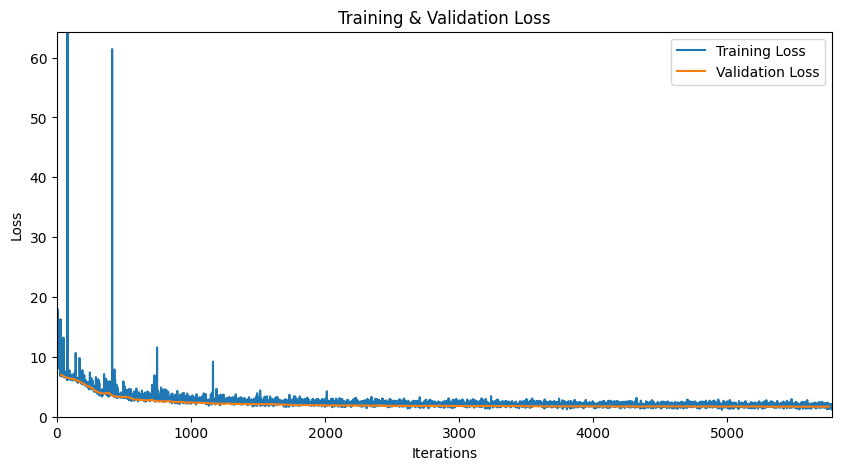

Epoch 9, Training loss: 1.8994488936807046
Epoch 9, Validation loss: 1.7037260106631689


In [338]:
from config import SAMPLE_RATE, WINDOW_SIZE
from modeling import custom_loss_function
from utils import create_bit_mask_of_frame_start_positions, frame_pos_to_nth_window

from torch.utils.data import DataLoader
# from IPython.display import clear_output, display
# import matplotlib.pyplot as plt

# Assume `train_dataset` is an instance of a custom Dataset class handling TIMIT data
# num_epochs = 10
num_epochs = 10
train_losses = []

train_loader = DataLoader(minimal_train_dataset, batch_size=BATCH_SIZE, collate_fn=collator) #shuffle=True
valid_loader = DataLoader(minimal_test_dataset, batch_size=BATCH_SIZE, collate_fn=collator) #shuffle=True

steps_taken = 0
progress_bar = tqdm(range(len(train_loader) * num_epochs))

# Create chart
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], label='Training Loss')
val_line, = ax.plot([], [], label='Validation Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss')
ax.legend()

validation_losses = []
validation_iterations = []

for epoch in range(num_epochs):
    train_loss = 0.0  # Add this line to initialize the training loss accumulator
    for batch in train_loader:    
        model.train()
        
        inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths = shape_model_parameters(batch)
        
        # Convert the input tensor to the same data type as the model parameters
        inputs = inputs.to(dtype=next(model.parameters()).dtype)

        phoneme_logits, start_idx_pred, _, _ = model(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)  # Forward pass

        num_windows_in_ea_sample = torch.floor_divide(torch.div(audio_lengths*1000, SAMPLE_RATE) - 5, WINDOW_SIZE).long()

        frame_positions = frame_pos_to_nth_window(frame_labels)
        frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_logits.shape[1]).to(device)

        loss, _, _ = custom_loss_function(
            phoneme_logits,
            start_idx_pred, 
            phoneme_labels, 
            frame_bitmask_labels,
            num_windows_in_ea_sample,
            phoneme_lengths,
            device=device
        )
        
        train_loss += loss.item()  # Add this line to accumulate the training loss
        train_losses.append(loss.item())
        
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        progress_bar.update(1)
        
        steps_taken += 1
        # break
        
        ## Plot train losses
        line.set_data(range(len(train_losses)), train_losses)
        ax.set_xlim(0, len(train_losses))
        ax.set_ylim(0, max(train_losses)) #max(train_losses)
        
        clear_output(wait=True)
        display(fig)
        
        if steps_taken % 32 == 0:
            model.eval()
            print('Running validation set against model...')
            val_loss = 0.0
            with torch.no_grad():
                for val_batch in valid_loader:
                    inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths = shape_model_parameters(val_batch)

                    # Inference and Loss Computation
                    phoneme_logits, start_idx_pred, log_probs, loss = model(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)

                    # Assuming `custom_loss_function` is defined and `frame_bitmask_labels` and `num_windows_in_ea_sample` are computed
                    frame_positions = frame_pos_to_nth_window(frame_labels)
                    frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_logits.shape[1]).to(device)
                    num_windows_in_ea_sample = torch.floor_divide(torch.div(audio_lengths*1000, SAMPLE_RATE) - 5, WINDOW_SIZE).long()

                    batch_val_loss, _, _ = custom_loss_function(
                        phoneme_logits,
                        start_idx_pred, 
                        phoneme_labels, 
                        frame_bitmask_labels,
                        num_windows_in_ea_sample,
                        phoneme_lengths,
                        device=device
                    )
                    
                    val_loss += batch_val_loss.item()

            val_loss /= len(valid_loader)
            validation_losses.append(val_loss)
            validation_iterations.append(steps_taken)

            # Plot validation losses
            val_line.set_data(validation_iterations, validation_losses)

    
    train_loss /= len(train_loader)  # Add this line to calculate the average training loss

    
    print(f"Epoch {epoch}, Training loss: {train_loss}")  # Add this line to print the average training loss
    print(f"Epoch {epoch}, Validation loss: {val_loss}")
    
plt.close(fig)

## Save model weights

In [339]:
# import torch
# from datetime import datetime
# from pathlib import Path

# # Get current date and time
# current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")

# # Create a filename with the datetime prefix
# model_filename = f"{current_datetime}_badbeagle_model.pth"

# # Create a Path object for the models directory and the full file path
# models_dir = Path("models")
# model_path = models_dir / model_filename

# # Create the models directory if it doesn't exist
# models_dir.mkdir(parents=True, exist_ok=True)

# # Save the model
# torch.save(model.state_dict(), model_path)

# print(f"Model saved as: {model_path}")

# Measure training performance

In [344]:
num_phonemes = 61
model_untrained = Wav2Vec2ForPhonemeAndFramePrediction(num_phonemes=61, freeze_feature_encoder=True)
model_untrained.to(device);

batch = next(iter(valid_loader))
idx = 6
batch = {
    'input_values': batch['input_values'][idx].unsqueeze(0), 
    'labels': { 
        'phoneme_start_idx': batch['labels']['phoneme_start_idx'][idx].unsqueeze(0), 
        'utterance': batch['labels']['utterance'][idx].unsqueeze(0) 
    }
}


Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([62]) in the model instantiated
- lm_head.weight: found shape torch.Size([32, 768]) in the checkpoint and torch.Size([62, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


INIT-ing with BatchNorm1d(1024)


## Run inference on trained + untrained model

In [348]:
from importlib import reload
import config
reload(config)
import utils
reload(utils)

from utils import frame_pos_to_nth_window, create_bit_mask_of_frame_start_positions


#### EXTRACT COMMON DATA FROM BATCH
inputs, phoneme_labels, frame_labels, audio_lengths, phoneme_lengths = shape_model_parameters(batch)

#### CREATE GROUND TRUTH FRAME MARKERS
frame_positions = frame_pos_to_nth_window(frame_labels)
frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_logits.shape[1]).to(device)
print(f"Frame markers - actual: ", frame_labels[0].shape)

num_windows_in_ea_sample = torch.floor_divide(torch.div(audio_lengths*1000, config.SAMPLE_RATE) - 5, config.WINDOW_SIZE).long()

#### [INFERENCE] TRAINED MODEL
phoneme_logits, start_idx_pred, log_probs, loss = model(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)
print(f"Frame markers - trained: ", start_idx_pred.shape)

loss, phoneme_loss, frame_start_loss = custom_loss_function(
    phoneme_logits, # FROM MODEL
    start_idx_pred, # FROM MODEL
    # -------
    phoneme_labels, # FROM BATCH
    frame_bitmask_labels, # FROM BATCH
    num_windows_in_ea_sample, # FROM BATCH
    phoneme_lengths, # FROM BATCH
    device=device 
)

#### [INFERENCE] UNTRAINED MODEL
phoneme_logits_UN, start_idx_pred_UN, log_probs_UN, loss_UN = model_untrained(inputs, phoneme_labels=phoneme_labels, frame_labels=frame_labels, return_log_probs=True)
print(f"Frame markers - untrained: ", start_idx_pred_UN.shape)

loss_UN, phoneme_loss_UN, frame_start_loss_UN = custom_loss_function(
    phoneme_logits_UN, # FROM MODEL
    start_idx_pred_UN,  # FROM MODEL
    # -------
    phoneme_labels, # FROM BATCH
    frame_bitmask_labels, # FROM BATCH
    num_windows_in_ea_sample, # FROM BATCH
    phoneme_lengths, # FROM BATCH
    device=device
)


#### [LOGGING]
print(f"Epoch {epoch}, TRAINED  | Frame Start Validation loss: {frame_start_loss.item()}")
print(f"Epoch {epoch}, UNTRAINED| Frame Start Validation loss: {frame_start_loss_UN.item()}")
print(f"Epoch {epoch}, TRAINED  | Phoneme loss: {phoneme_loss.item()}")
print(f"Epoch {epoch}, UNTRAINED| Phoneme loss: {phoneme_loss_UN.item()}")

Frame markers - actual:  torch.Size([60])
Shape: torch.Size([1, 248, 768])
Shape: torch.Size([1, 248, 768])
Frame markers - trained:  torch.Size([1, 248])
Shape: torch.Size([1, 248, 768])
Shape: torch.Size([1, 248, 768])
Frame markers - untrained:  torch.Size([1, 248])
Epoch 9, TRAINED  | Frame Start Validation loss: 0.05512337386608124
Epoch 9, UNTRAINED| Frame Start Validation loss: 27.349441528320312
Epoch 9, TRAINED  | Phoneme loss: 0.4886504113674164
Epoch 9, UNTRAINED| Phoneme loss: 15.992880821228027


## Actual vs. predicted Frame Marker positions

In [411]:
from plots import visualize_bitmask
from utils import get_audio_length_in_windows

# visualize_bitmask(frame_bitmask_labels.squeeze(0), start_idx_pred.squeeze(0), start_idx_pred_UN.squeeze(0))
# visualize_bitmask(frame_bitmask_labels.squeeze(0), start_idx_pred.squeeze(0), start_idx_pred.squeeze(0) > 0.6)
# sample_idx = batch['labels']['phoneme_start_idx'][0]
# frame_pos_to_nth_window(sample_idx)
get_audio_length_in_windows(batch['input_values'][0])
len(batch['input_values'][0]) / SAMPLE_RATE

import IPython.display as ipd
ipd.Audio(batch['input_values'][0].cpu().numpy(), rate=SAMPLE_RATE)

## Spectrogram + Framestart marker overlay

In [409]:
from utils import get_audio_length_in_windows

print(frame_pos_to_nth_window(batch['input_values'].shape[1]))
print(get_audio_length_in_windows(batch['input_values'][0]))



tensor(248.)
248


(1025, 156)
(513, 311)
(1025, 156)
(513, 311)


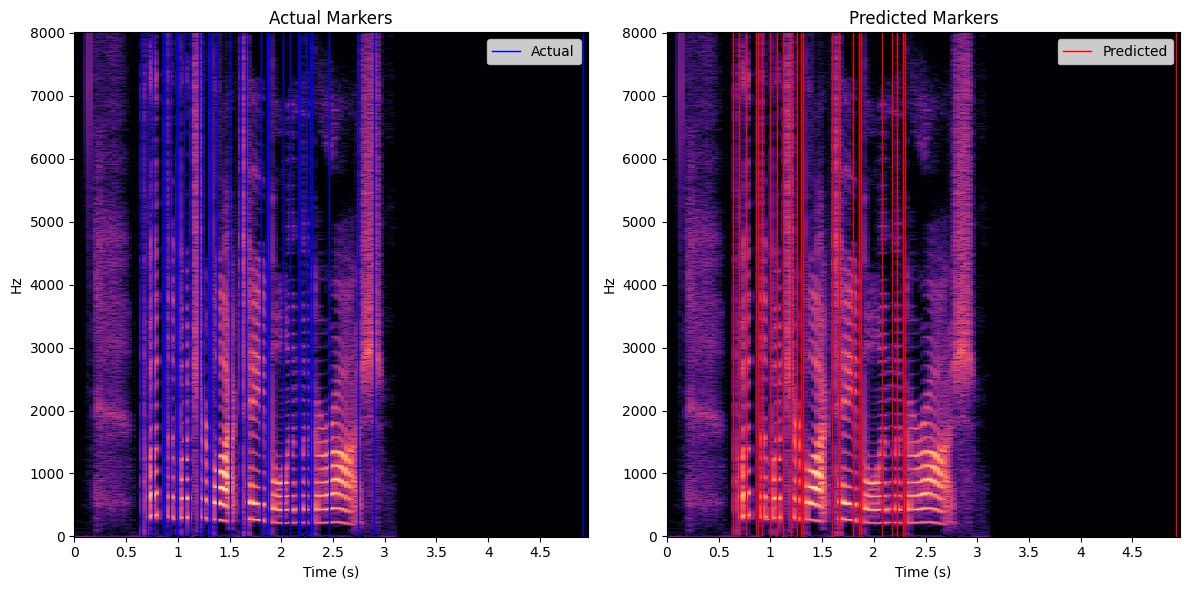

In [461]:
# Variables that must be in scope before this code begins:
# - batch: a dictionary containing 'input_values' and 'labels'
# - start_idx_pred: tensor of predicted start indices
# - frame_pos_to_nth_window: function to convert frame positions to window indices
# - create_bit_mask_of_frame_start_positions: function to create bitmask from start positions
# - device: the device (CPU or GPU) to use for tensor operations

from plots import visualize_audio_and_markers
from utils import get_audio_length_in_windows

inputs, label = batch['input_values'], batch['labels']

sample_index = 0 
sample = inputs[sample_index]
# The window indices
start_window = 0  
end_window = len(start_idx_pred[0]) 

# Get bitmask / start markers
sample_start_idx = label['phoneme_start_idx']
window_start_idx_actual = frame_pos_to_nth_window(sample_start_idx)
num_of_windows = get_audio_length_in_windows(sample)
start_idx_bitmask_actual = create_bit_mask_of_frame_start_positions(
    window_start_idx_actual,
    num_of_windows
).to(device)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

visualize_audio_and_markers(
    sample,
    start_window,
    end_window,
    start_idx_bitmask_actual[sample_index],
    label_type='Actual',
    color='blue',
    ax=ax1
)
ax1.set_title('Actual Markers')


visualize_audio_and_markers(
    sample,
    start_window,
    end_window,
    start_idx_pred[sample_index] > 0.6,
    label_type='Predicted',
    color='red',
    ax=ax2
)
ax2.set_title('Predicted Markers')

plt.tight_layout()
plt.show()

# [sample for sample in start_idx_pred[sample_index] if sample < 0 or sample > 1]